# Setup & Imports

In [1]:
!pip install torchsummary seaborn --quiet

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Data Preparation

In [2]:
DATASET_PATH = '/kaggle/input/fruitvision-a-benchmark-dataset-for-fresh/Fruits Original'  # Change if needed

# Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transforms)

dataset_size = len(full_dataset)
indices = list(range(dataset_size))
random.shuffle(indices)

train_end = int(0.7 * dataset_size)
val_end = train_end + int(0.15 * dataset_size)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train size: {len(train_dataset)},Val size: {len(val_dataset)},Test size: {len(test_dataset)}")


Train size: 7107,Val size: 1523,Test size: 1524


# Sample Image Visualization

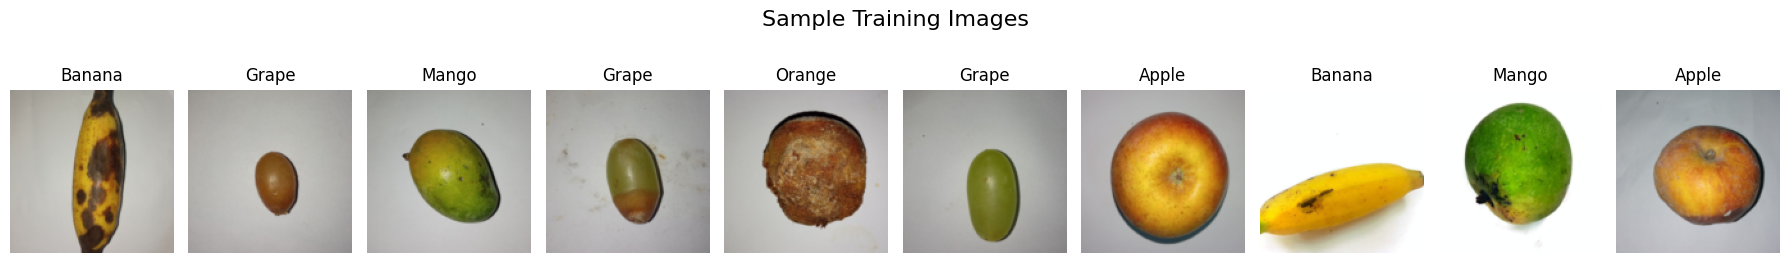

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

images, labels = next(iter(train_loader))

fig, axs = plt.subplots(1, 10, figsize=(18, 3))
fig.suptitle("Sample Training Images", fontsize=16)

for i in range(10):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * std + mean  
    img = np.clip(img, 0, 1)
    axs[i].imshow(img)
    axs[i].set_title(full_dataset.classes[labels[i]])
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# Model Definition

In [4]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.1),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.15),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(full_dataset.classes)
model = CustomCNN(num_classes).to(device)
summary(model, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
           Dropout-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

# Training

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_f1 = 0.0
train_losses, val_losses, val_f1s = [], [], []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'custom_cnn_best.pt')
        print("Best model saved!")

print("Training complete!")
print("Files in current directory after training:")
print(os.listdir())
print(f"Best Validation F1: {best_f1:.4f}")


Epoch [1/10] Train Loss: 0.9855 Val Loss: 1.0402 Val F1: 0.7094
Best model saved!
Epoch [2/10] Train Loss: 0.2207 Val Loss: 0.3702 Val F1: 0.8630
Best model saved!
Epoch [3/10] Train Loss: 0.1304 Val Loss: 0.0739 Val F1: 0.9770
Best model saved!
Epoch [4/10] Train Loss: 0.1103 Val Loss: 0.0978 Val F1: 0.9717
Epoch [5/10] Train Loss: 0.1092 Val Loss: 0.0721 Val F1: 0.9783
Best model saved!
Epoch [6/10] Train Loss: 0.0653 Val Loss: 0.3769 Val F1: 0.9051
Epoch [7/10] Train Loss: 0.0889 Val Loss: 0.0357 Val F1: 0.9895
Best model saved!
Epoch [8/10] Train Loss: 0.0663 Val Loss: 0.0654 Val F1: 0.9737
Epoch [9/10] Train Loss: 0.1053 Val Loss: 1.1027 Val F1: 0.8121
Epoch [10/10] Train Loss: 0.1181 Val Loss: 0.1055 Val F1: 0.9671
Training complete!
Files in current directory after training:
['custom_cnn_best.pt', '.virtual_documents']
Best Validation F1: 0.9895


# Plotting Curves

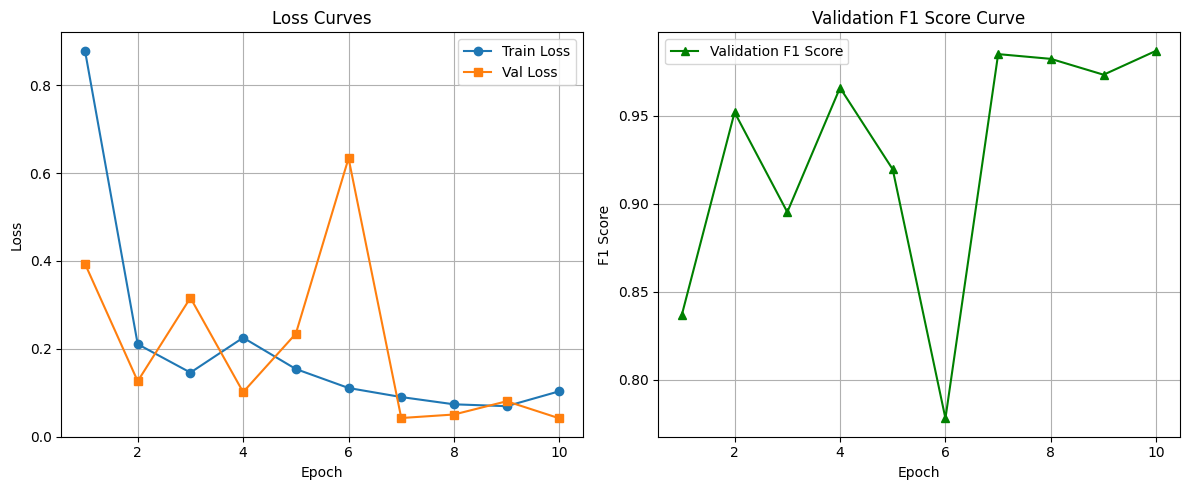

In [7]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1s, label='Validation F1 Score', color='green', marker='^')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Evaluation on Test Set


📊 Classification Report:

              precision    recall  f1-score   support

       Apple       1.00      0.95      0.97       310
      Banana       0.99      1.00      0.99       303
       Grape       1.00      1.00      1.00       313
       Mango       0.99      0.98      0.99       312
      Orange       0.95      1.00      0.97       286

    accuracy                           0.98      1524
   macro avg       0.98      0.99      0.98      1524
weighted avg       0.99      0.98      0.98      1524

✅ Test Accuracy: 0.9849


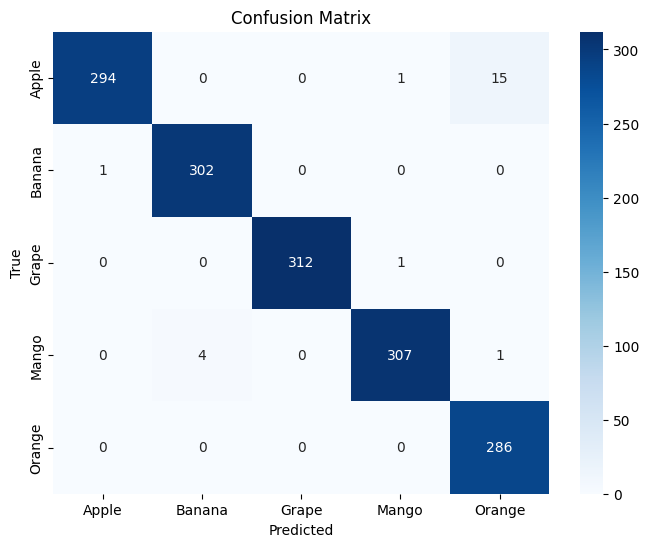

In [8]:
model.load_state_dict(torch.load('custom_cnn_best.pt', map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# README.md content suggestion

# Group C - Custom CNN for Fruit Classification - CSE 366 Lab Assignment

## Group Members
- Asfar Hossain Sitab ID: 2022-3-60-275
- Parmita Hossain Simia ID: 2022-3-60-253
- Mushfida Ferdaous Maisha ID: 2022-3-60-264
- Ramiz Fariha Risha ID: 2022-3-60-274

## Dataset
- Fruits Original Dataset  
- Dataset Path: `/kaggle/input/fruitvision-a-benchmark-dataset-for-fresh/Fruits Original`



## Reproduction Steps
1. Clone the notebook.
2. Set the dataset path if different.
3. Run all cells sequentially.
4. The model weights `custom_cnn_best.pt` will be saved in the working directory.
5. The notebook outputs training logs, plots, and test set evaluation.


